# Mask Detection using MobilenetV2

Here is a step by step guide to make a classifier that can classify the faces as wearing mask, not wearing a mask and not wearing a mask properly.

The biggest challenge is here to convert the available data to the form we can use it. It is going to take most of our time.So let us explore the data. Our dataset contains two folders, one having images and other having annotations.Since each of these images contain multiple persons which are either wearing a mask or not weraing it or not wearing it properly, we need to get these faces out of the images.

The annotations file of each file will help in that as it contains information about where the face it and under which category does  it fall

So here a brief summary of what we are going to do here
1. First we are going to go through all the annotations file and parse the information using beautifulsoap.Later we are going to make a list which contains a dictionary having information about coordinates of faces and the labels of each face. 
2. Next we will use opencv to read the image , extract the face ares from it, preprocess it and save it to a list.We are going to save the labels simuntaneosly in another list
3. Now we will finetune the MobilenetV2 model and get the results.

Also to know how to  use this model to detect the masks in real time on a webcam feed, follow the article [Mask detection using openCV](https://www.mygreatlearning.com/blog/real-time-face-detection).




In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/images/maksssksksss826.png
/kaggle/input/face-mask-detection/images/maksssksksss750.png
/kaggle/input/face-mask-detection/images/maksssksksss340.png
/kaggle/input/face-mask-detection/images/maksssksksss453.png
/kaggle/input/face-mask-detection/images/maksssksksss454.png
/kaggle/input/face-mask-detection/images/maksssksksss150.png
/kaggle/input/face-mask-detection/images/maksssksksss493.png
/kaggle/input/face-mask-detection/images/maksssksksss318.png
/kaggle/input/face-mask-detection/images/maksssksksss637.png
/kaggle/input/face-mask-detection/images/maksssksksss533.png
/kaggle/input/face-mask-detection/images/maksssksksss563.png
/kaggle/input/face-mask-detection/images/maksssksksss678.png
/kaggle/input/face-mask-detection/images/maksssksksss29.png
/kaggle/input/face-mask-detection/images/maksssksksss9.png
/kaggle/input/face-mask-detection/images/maksssksksss138.png
/kaggle/input/face-mask-detection/images/maksssksksss311.png
/kaggle/input/face-mask-det

In [1]:
#import the libraries
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand

In [30]:
# Defiine functions that performs task 1 mentioned above

#This function will get the coordinates of face given in the annotations file
# the coordinates of lower left corner and upper right corner
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0
#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [31]:
imgs = list(sorted(os.listdir("/kaggle/input/face-mask-detection/images/")))
len(imgs)

853

In [32]:
labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

In [33]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/kaggle/input/face-mask-detection/images/", file_image)
    label_path = os.path.join("/kaggle/input/face-mask-detection/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)
    

In [34]:
#In this step we carry forward the second step mentioned above.
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"../input/face-mask-detection/images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)



Next we check total number of faces detected and how many belong to each class. We see that the images in which mask is woren properly are really less. We will increase their weight when training the model.

In [35]:
len(face_labels)

4072

In [36]:
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

{0: 717, 1: 3232, 2: 123}

In [38]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [39]:
#Perform data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [2]:
#define the model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 61s 6us/step


In [77]:
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [43]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [44]:
#Free some space.I did this tep as the notebook was running out of space while training
del targets,face_images,face_labels

In [83]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10}) #Here we sets weights to each class. 
#Class having high weight will be considered more importat while training

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
101/101 [==============================] - 38s 381ms/step - loss: 1.6725 - accuracy: 0.6933 - val_loss: 0.6502 - val_accuracy: 0.7202
Epoch 2/20
101/101 [==============================] - 36s 359ms/step - loss: 1.2593 - accuracy: 0.7848 - val_loss: 0.4817 - val_accuracy: 0.8147
Epoch 3/20
101/101 [==============================] - 37s 368ms/step - loss: 1.1238 - accuracy: 0.8096 - val_loss: 0.4941 - val_accuracy: 0.8135
Epoch 4/20
101/101 [==============================] - 36s 356ms/step - loss: 1.0348 - accuracy: 0.8220 - val_loss: 0.5078 - val_accuracy: 0.8123
Epoch 5/20
101/101 [==============================] - 36s 355ms/step - loss: 0.9835 - accuracy: 0.8391 - val_loss: 0.5005 - val_accuracy: 0.8049
Epoch 6/20
101/101 [==============================] - 36s 357ms/step - loss: 0.9440 - accuracy: 0.8338 - val_loss: 0.3574 - val_accuracy: 0.8650
Epoch 7/20
101/101 [==============================] - 36s 359ms/step - loss: 0.8

The next step is o evaluate the model and plot the graphs showing the learning process.In the plot we can see when the the training stopped,the model was still improving, thus we save the model and train it again from the point we left.

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.62      0.92      0.74       143
           1       0.97      0.85      0.91       647
           2       0.39      0.48      0.43        25

    accuracy                           0.85       815
   macro avg       0.66      0.75      0.69       815
weighted avg       0.89      0.85      0.86       815



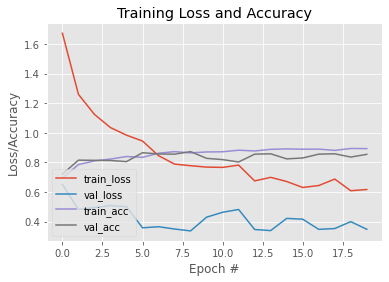

In [85]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [95]:
#save the model and name it as you wish.
model.save('kaggle1.h5')

In [92]:
#load the saved model
import keras
model = keras.models.load_model('kaggle1.h5')

In [93]:
#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
101/101 [==============================] - 39s 390ms/step - loss: 0.4797 - accuracy: 0.9212 - val_loss: 0.2948 - val_accuracy: 0.8810
Epoch 2/20
101/101 [==============================] - 38s 375ms/step - loss: 0.3979 - accuracy: 0.9287 - val_loss: 0.2963 - val_accuracy: 0.8859
Epoch 3/20
101/101 [==============================] - 37s 363ms/step - loss: 0.4303 - accuracy: 0.9240 - val_loss: 0.2703 - val_accuracy: 0.8920
Epoch 4/20
101/101 [==============================] - 38s 380ms/step - loss: 0.4262 - accuracy: 0.9231 - val_loss: 0.2441 - val_accuracy: 0.9031
Epoch 5/20
101/101 [==============================] - 37s 362ms/step - loss: 0.4215 - accuracy: 0.9262 - val_loss: 0.3042 - val_accuracy: 0.8785
Epoch 6/20
101/101 [==============================] - 37s 366ms/step - loss: 0.4456 - accuracy: 0.9222 - val_loss: 0.3471 - val_accuracy: 0.8650
Epoch 7/20
101/101 [==============================] - 38s 372ms/step - loss: 0.4

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.72      0.91      0.80       143
           1       0.97      0.91      0.94       647
           2       0.50      0.52      0.51        25

    accuracy                           0.90       815
   macro avg       0.73      0.78      0.75       815
weighted avg       0.91      0.90      0.90       815



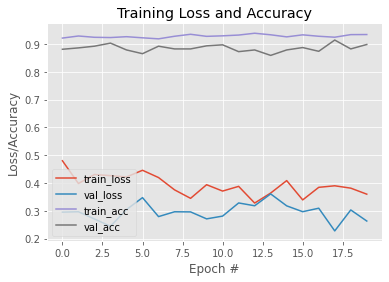

In [94]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

As you can see the performance of the model increased after training again for about 20 epochs(I ran the training cell twice by mistake so in the graph you cannot see that the model has started training from where I left)

When testing this model on my webcam, I found it was not much reliable as if you cover your face with hand,it ll show you are wearing the mask. I have made another model but that can only detect if the person is wearing a mask or not.The model works exceptionally well abd better than this model as it cannot be fooled with a hand over mouth.Here is the link to the article [Real time mask detection using OpenCV](https://www.mygreatlearning.com/blog/real-time-face-detection)

[Here is a link to the youtube video showing results of this model on webcam stream](https://youtu.be/HFNxRrirj2s)